In [1]:
import sys;
sys.path.append(r'.') 
from heisenberg_model import HeisenbergModel; 


<ipython-input-1-4a74d8e17f45>:3: NatureDeprecationWarning: The qiskit_nature.operators package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.operators package.
  from heisenberg_model import HeisenbergModel;


# 1 Introduction
## 1-1 Quantum State Preparation
Quantum state preparation is fundamental to quantum computing. It lies at the heart of quantum algorithms, quantum machine learning, quantum error correction, and quantum physics research, but it can be very difficult to start from an initial state $|0\dots 0 \rangle$ and efficiently prepare an arbitrary state $|\psi \rangle$ with high fidelity. Your objective for this year's Open Science Prize is to significantly improve state-of-the-art state preparation in the context of the Variational Quantum Eigensolver (VQE) algorithm.

The state you will prepare is the highly entangled ground state of a Heisenberg spin-1/2 model on a kagome lattice. That sentence is jam packed with physics jargon, but do not despair. Though the problem statement originates deep within quantum physics research, we will avoid jargon as much as possible. A deep dive into the physics literature (which is very fascinating) is left as an exercise for the reader.

Why the ground state of a Heisenberg model? Well, the ground state of a system is it's lowest energy configuration, and the ground state tends to be where exciting and unexpected quantum affects flourish. For example, when the element Mercury is cooled down near its ground state (below 4 Kelvin), it has no electrical resistance. None. Zero! Near its thermal ground state, a chunk of Mercury is [a superconductor](https://en.wikipedia.org/wiki/History_of_superconductivity). Researchers have been trying to understand what materials exhibit superconductivity and how it's even possible ever since it was first discovered. If that isn't cool enough for you, consider the [Bose-Einstein condensate](https://en.wikipedia.org/wiki/Bose–Einstein_condensate). This is quantum phase of matter where a dilute gas of individual atoms (bosonic atoms such as [Rubidium](https://en.wikipedia.org/wiki/Rubidium))--when cooled to their ground state--effectively become one giant particle!

A system's ground state determines important and fascinating physical properties (see the two examples highlighted above), yet some quantum systems have ground states (and their associated energies) which are difficult to make and measure in the lab as well as being intractable for classical computers to calculate. The Variational Quantum Eigensolver (VQE) is a promising quantum algorithm that could find these ground states and their energies.

You will implement the VQE algorithm on [ibmq_guadalupe](https://quantum-computing.ibm.com/services/resources?system=ibmq_guadalupe) a 16 qubit [heavy-hex](https://research.ibm.com/blog/heavy-hex-lattice) device. This is the largest device used in an Open Science Prize to date. Working with more qubits presents its own challenges. Be mindful of how your solution scales as this will be part of the judging criteria this year.

We'll get more into the principles of VQE later, but for now, remember that VQE relies on iterative cycles of quantum and classical computation. Fast iterations and fast communication between the classical and quantum computer are essential for a fast VQE, and [Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) does just that. [Qiskit runtime](https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742) is a programming model and containerized environment designed to reduce the computational cycle time between quantum and classical computers. Later in this notebook, we will demonstrate how to leverage the latest release of runtime for fast VQE.

The notebook is organized as follows: Section 1 gives a brief introduction to the Heisenberg model, the kagome lattice, and VQE algorithm. It also provides a classical calculation of the ground state(s) energy. Section 2 introduces how to construct a VQE experiment and simulate it on your local computer. Section 3 introduces Qiskit runtime and how to run VQE on a cloud simulator or real backend. Finally, if you are feeling stuck, we've provided some questions to consider as you design and implement your solution.

#### Objective
**Your task is to use the VQE algorithm to compute the ground state of a Heisenberg spin-1/2 system on a kagome lattice unit cell with the lowest possible relative error of the measured state's energy expectation value wrt to the exact value.** There are actually two ground states in this specific case, and you may prepare any combination of the two including only one or the other.


## 1-2 Heisenberg spin-1/2 model on the kagome lattice
For the Open Science Prize, (get ready for some jargon) you will work with the antiferromagnetic $XXX$ Heisenberg model arranged on a kagome lattice. The $XXX$ Heisenberg model Hamiltonian for this Prize will be defined as
$$
\begin{equation}
H = \sum_{\langle i j \rangle}^N X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}
\end{equation}
$$
where $\langle i j \rangle$ is sum over neighboring spins and $X$, $Y$, and $Z$ are the usual Pauli matrices. The Heisenberg model hosts a wide variety of exotic quantum physics all of which heavily depend on the arrangement of the spins. The arrangement we are interested in is a kagome lattice.

![title](kagome_unit_cell.png)

The kagome lattice is a unique lattice structure made up of corner-sharing triangles (see the unit cell above). In general, the kagome lattice (i.e. many unit cells tiled together) is theorized to host a fascinating quantum phase of matter called a quantum spin liquid--a research topic at the forefront of quantum physics [1-3]. Additionally, excitations from that ground state are theorized to show exotic quantum behavior such a fractionalized particle excitations [1-3]. For those interested in a deeper dive into the physics check out Refs. [1-3] and other papers.

This year's Prize will focus on a single unit cell (the base pattern shown above) which has 12 spin-1/2 particles represented in as blue dots in the image below. Each spin will be represented by a single qubit. The lines connecting the spin-1/2 particles called edges--borrowing a term from [graph theory](https://en.wikipedia.org/wiki/Graph_theory)--and they specify which spins are neighbors.

\[1\] "Modern condensed matter physics." Girvin, Steven M., and Kun Yang. Cambridge University Press, (2019).

\[2\] "Spin liquids in frustrated magnets." Balents, Leon. [Nature 464, 199–208](https://doi.org/10.1038/nature08917) (2010). 

\[3\] "Probing topological spin liquids on a programmable quantum simulator." Semeghini, Giulia, et al. [Science 374.6572: 1242-1247.](https://www.science.org/doi/10.1126/science.abi8794) (2021). [arXiv link](https://arxiv.org/abs/2104.04119)

\[4\] "Kagome: The Story of the Basketweave Lattice." Mekata, Mamoru. [Physics Today 56, 2, 12](https://physicstoday.scitation.org/doi/10.1063/1.1564329) (2003).

## 1-3 VQE
The Variational Quantum Eigensolver (VQE) is a quantum algorithm that can find the ground state(s) of a given Hamiltonian [5-7]. The VQE algorithm is based on the [variational principle](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) of quantum mechanics and relies on both quantum and classical computations. Below, we briefly sketch out the main principles of VQE, and encourage you to review educational material and the research literature for details.

Given a Hamiltonian $H$ and ground state $|\psi_g \rangle$, the variational principle says that even if we don't know the exact ground state an approximate ground state $|\tilde{ \psi}_g\rangle \approx |\psi_g \rangle$ can be found. To find the approximate ground state $|\tilde{ \psi}_g\rangle$, we start with a parameterized state called an ansatz $|\psi(\boldsymbol{\theta})\rangle$ where $\boldsymbol{\theta} \equiv (\theta_1, \theta_2,\dots)$ are the parameters. In theory, there is a combination of parameter values where the anstaz approximates the ground state $|\psi(\boldsymbol{\theta})\rangle \approx |\psi_g\rangle$, but we need a way to find those parameter values. This is done with a combination of quantum and classical computing.

To optimize the parameters, many cycles of quantum and classical computing drive the ansatz toward the approximate ground state. The quantum computer computes the energy expectation value of Hamiltonian $H$ acting on the the parameterized anstaz for a given set of parameter values
$$
E(\boldsymbol{\theta}) = \langle \psi(\boldsymbol{\theta}) | H | \psi(\boldsymbol{\theta}) \rangle \;.
$$
For those familiar with optimization terminology this is the cost function. A classical computer uses the measurement data from the quantum computer to determine how the parameters values should be adjusted to further minimize the energy $E(\boldsymbol{\theta})$. As the classical and quantum computer loop through many iterations, they search the parameter space and converge to the approximate ground state.

How can we know the state that gives the minimum energy expectation value is the ground state? The variation principle guarantees that the minimal energy expectation value can only be achieved if the quantum state is the ground state. No other state can give a lower energy--hence the name ground state. In this way, we can be confident that minimizing $E(\boldsymbol{\theta})$ with respect to the parameters $\boldsymbol{\theta}$ will drive the ansatz toward an accurate approximation of the true ground state and not some other state.

Of course, the actual implementation of the algorithm comes with challenges. The ansatz $|\psi(\boldsymbol{\theta})\rangle$ may never reach the ground state for any combination of parameters. The ansatz could have too many parameters and encounter a barren plateau during optimization. When implementing the VQE, it may take an unreasonable amount of time to execute the ansatz or measure the expectation value on quantum hardware. The quantum hardware may be too noisy. The classical optimizer may not pair well with the optimization landscape or the level of noise from the quantum measurements. Etc.

To jump into more details about VQE, we included three review articles on the topic below. We encourage you to review additional educational material and research literature as you work out your solution.

\[5\] "A variational eigenvalue solver on a quantum processor." A. Peruzzo, et al. [arXiv:1304.3061](https://arxiv.org/abs/1304.3061) [quant-ph] (2013).

\[6\] "Variational quantum algorithms." M. Cerezo, et al. [arXiv:2012.09265v2](https://arxiv.org/abs/2012.09265v2) [quant-ph] (2021).

\[7\] "The Variational Quantum Eigensolver: a review of methods and best practices." J. Tilly, et al. [arXiv:2111.05176v3](https://arxiv.org/abs/2111.05176v3) [quant-ph] (2022).


In [2]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

## 1-4 Classical computation of ground state energy
The twelve qubit state space isn't terribly large $2^{12} = 4096$, but it also isn't small. A classical computer can still diagonalize the Hamiltonian and thus compute the ground state and its associated energy. For the Open Science Prize, we don't need a full energy spectrum, just a calculation of the ground state energy. When working on your solution, remember that brute force approaches that work on 5 or 7-qubit devices may not work as well with ibmq_guadalupe's 16 qubits.

Below is an example classical calculation of the ground state energy. It will be used as a reference to your VQE results. First, the kagome lattice is defined on a graph. Second, we built the Hamiltonian from the graph edges. Finally, the expected ground state energy is calculated.

### Qiskit nature kagome unit cell
Using Qiskit nature's [`Lattice` object](https://qiskit.org/documentation/nature/tutorials/10_lattice_models.html), we can represent any spin lattice as a graph. Here we construct the unit cell of a kagome lattice by defining a list of edges between the twelve sites. This `Lattice` representation will be convenient to use when defining the $XXX$ Hamiltonian terms.

In [3]:
#import retworkx as rx
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

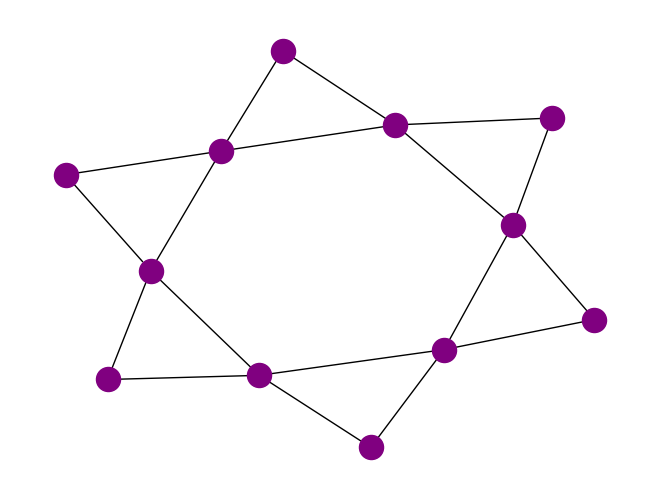

In [4]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
original_edge_list = edge_list
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

Now that we have the lattice geometry, we can place each term in the Hamiltonian on its corresponding edge. This is done by using the custom `HeisenbergModel` found in the heisenberg_model.py file. This model is based on Qiskit Nature's [`IsingModel` class](https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.lattice.IsingModel.html) . It places $XX + YY + ZZ$ on each edge of the lattice (per the Hamiltonian's definition).

We will also need to specify how the spin-1/2 particles map to qubits. Using Qiskit nature's `LogarithmicMapper`, we can map each spin-1/2 site to a single qubit. For more information on Qiskit nature's spin mappings see [here]( https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.SpinMapper.html#qiskit_nature.mappers.second_quantization.SpinMapper).

In [5]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [6]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

### Compute ground state energy
With the Hamiltonian in hand, we can now calculate the expected ground state and its energy. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

Below is an example calculation of finding the lowest 3 energies ($k=3$) of the system using the second method. Remember that for this year's Prize, you will only need to use VQE to find the ground state energy and not any excited state energies.

In [7]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


You'll note that -18 is found twice. This means there are actually two ground states for this system. The -16.96 energy is the first excited state, which is not part of this year's challenge. **For this year's Prize, we will only be judging based off the measured ground state energy. This means it does not matter which of the two ground states, or combination of them, your VQE implementation finds.**

## 2-1 VQE with local runtime primitives

To compute the ground state energy using VQE, we first pick an appropriate device. This year's Prize will use ibmq_guadalupe which has 16 qubits. This is 4 extra qubits than the Hamiltonian, so we will need to "inflate" the Hamiltonian with identity operators so we can measure 12 qubit Hamiltonian's energy expectation value on a 16 qubit device.
After inflating the Hamiltonian, the anstaz and classical optimizer components are built up. Finally, a class is defined to bring everything together for the VQE algorithm, and it's executed on a local simulator.

The code below is largely based off of this example [tutorial](https://github.com/mberna/qce22-qiskit-runtime-tutorial/blob/main/docs/tutorials/Building%20algorithms%20with%20Qiskit%20Runtime.ipynb) of using qiskit runtime primitives from IEEE week. Feel free to read through to learn more about qiskit runtime and VQE.

## 2-2 Qiskit runtime

[Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) is a paradigm which brings classical and quantum computing resources closer together--speeding up quantum algorithms especially variational ones. We will be using runtime because of its [speed boost](https://research.ibm.com/blog/120x-quantum-speedup) relative to the traditional way quantum circuits are executed using qiskit. In this notebook, we'll demonstrate an example VQE executed with qiskit runtime, but we encourage you to get a deeper understanding of the tool by checking out an overview of qiskit runtime and some tutorials on the [qiskit docs section on runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) as well as the IBM [research blog](https://research.ibm.com/blog/qiskit-runtime-capabilities-integration).

In [8]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector

from qiskit import IBMQ

In [9]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()
#guadalupe = noisy_sim

As mentioned at the beginning of this section, the system Hamiltonian is defined over 12 qubits, but ibmq_guadalupe has 16 qubits. To execute VQE on ibmq_guadalupe, we will "inflate" the Hamilontian from 12 qubits to 16 qubits to match ibmq_guadalupe, but those extra 4 qubits will not participate in the energy expectation value. Here, we've chosen the 4 qubits that won't participate to be 0, 6, 9, 15. You may pick different qubits.

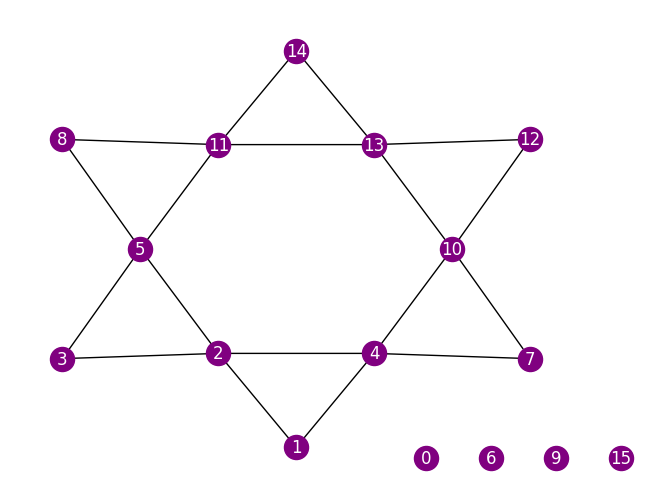

In [10]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [11]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

## 2-3 Define an ansatz
Crafting the ansatz is critical to VQE. You may use a prebuilt ansatz from the [qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits). You may also make your own custom ansatz. Keep in mind that a custom ansatz should have no measurement gates at the end and the circuit parameters are defined by using `Parameter()` [objects](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html). We've demonstrated both options below. The ansatz can be defined over 12 qubits without needed to inflate it to 16 qubits at this point. The transpiler will take care of that later on.

Here's an example using `EfficientSU2()` to generate an ansatz

# Pulse specific settings

In [35]:
backend = provider.get_backend('ibmq_guadalupe')

# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 1  ### CAN BE >= 4
t = target_time/(trotter_steps)
# Initialize quantum circuit for 3 qubits
size = 12
qr = QuantumRegister(size)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

def compute_XX_pulsegate(t_param, first, second, size):
    XX_qr = QuantumRegister(size)
    XX_qc = QuantumCircuit(XX_qr, name='XX' + str(first))
    XX_qc.ry(np.pi/2,[first,second])
    XX_qc.h(second)
    XX_qc.rzx(t_param, first, second)
    XX_qc.x(first)
    XX_qc.rzx(-t_param, first, second)
    XX_qc.x(first)
    XX_qc.h(second)
    XX_qc.ry(-np.pi/2,[first,second])
    return XX_qc

def compute_YY_pulsegate(t_param, first, second, size):
    YY_qr = QuantumRegister(size)
    YY_qc = QuantumCircuit(YY_qr, name='YY' + str(first))
    YY_qc.rx(np.pi/2,[first,second])
    YY_qc.h(second)
    YY_qc.rzx(t_param, first, second)
    YY_qc.x(first)
    YY_qc.rzx(-t_param, first, second)
    YY_qc.x(first)
    YY_qc.h(second)
    YY_qc.rx(-np.pi/2,[first,second])
    return YY_qc

def compute_ZZ_pulsegate(t_param, first, second, size):
    ZZ_qr = QuantumRegister(size)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ' + str(first))
    ZZ_qc.h(second)
    ZZ_qc.rzx(t_param, first, second)
    ZZ_qc.x(first)
    ZZ_qc.rzx(-t_param, first, second)
    ZZ_qc.x(first)
    ZZ_qc.h(second)
    return ZZ_qc

target_qubits = []
for x in range(size):
    target_qubits.append(x)

p = ParameterVector('p', (size-1)*size*trotter_steps)
param_index = 0
for i in range(1,trotter_steps+1):    
        
    if i%2 == 1:
        for j in range(size):
            # Symmetrization
            qc.h(j)
        
    # XX of 1,3
    for j in range(size-1):
        print("X ", p[param_index], t, p[param_index]*t)
        qc.append(compute_XX_pulsegate(p[param_index] * t, j, j+1, size), target_qubits)
        param_index = param_index + 1
    
    for j in range(size-1):
        qc.append(compute_YY_pulsegate(p[param_index] * t, j, j+1, size), target_qubits)
        param_index = param_index + 1

    for j in range(size-1):
        qc.append(compute_ZZ_pulsegate(p[param_index] * t, j, j+1, size), target_qubits)
        param_index = param_index + 1
        
    # Hadamard for Symmetrization
    if i%2 == 1:
        for j in range(size):
            # Symmetrization
            qc.h(j)

qc.decompose().draw()

X  p[0] 3.141592653589793 3.14159265358979*p[0]
X  p[1] 3.141592653589793 3.14159265358979*p[1]
X  p[2] 3.141592653589793 3.14159265358979*p[2]
X  p[3] 3.141592653589793 3.14159265358979*p[3]
X  p[4] 3.141592653589793 3.14159265358979*p[4]
X  p[5] 3.141592653589793 3.14159265358979*p[5]
X  p[6] 3.141592653589793 3.14159265358979*p[6]
X  p[7] 3.141592653589793 3.14159265358979*p[7]
X  p[8] 3.141592653589793 3.14159265358979*p[8]
X  p[9] 3.141592653589793 3.14159265358979*p[9]
X  p[10] 3.141592653589793 3.14159265358979*p[10]


┌─────────┐┌─────────┐     ┌──────────────┐┌───┐┌───────────────┐┌───┐»
 q61_0: ┤ U2(0,π) ├┤ Ry(π/2) ├─────┤0             ├┤ X ├┤0              ├┤ X ├»
        ├─────────┤├─────────┤┌───┐│  Rzx(π*p[0]) │└───┘│  Rzx(-π*p[0]) │├───┤»
 q61_1: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├┤1             ├─────┤1              ├┤ H ├»
        ├─────────┤├─────────┤├───┤└──────────────┘     └───────────────┘└───┘»
 q61_2: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_3: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_4: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_5: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_6: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_7: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_8: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
 q61_9: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
q61_10: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        ├─────────┤├─────────┤├───┤                                           »
q61_11: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├───────────────────────────────────────────»
        └─────────┘└─────────┘└───┘                                           »
«        ┌──────────┐┌─────────┐                                           »
« q61_0: ┤ Ry(-π/2) ├┤ Rx(π/2) ├───────────────────────────────────────────»
«        ├──────────┤├─────────┤┌──────────────┐┌───┐┌───────────────┐┌───┐»
« q61_1: ┤ Ry(-π/2) ├┤ Ry(π/2) ├┤0             ├┤ X ├┤0              ├┤ X ├»
«        └──────────┘└─────────┘│  Rzx(π*p[1]) │└───┘│  Rzx(-π*p[1]) │├───┤»
« q61_2: ───────────────────────┤1             ├─────┤1              ├┤ H ├»
«                               └──────────────┘     └───────────────┘└───┘»
« q61_3: ──────────────────────────────────────────────────────────────────»
«                                                                          »
« q61_4: ──────────────────────────────────────────────────────────────────»
«                                                                          »
« q61_5: ──────────────────────────────────────────────────────────────────»
«                                                                          »
« q61_6: ──────────────────────────────────────────────────────────────────»
«                                                                          »
« q61_7: ──────────────────────────────────────────────────────────────────»
«                                                                          »
« q61_8: ──────────────────────────────────────────────────────────────────»
«                                                                          »
« q61_9: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«q61_10: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«q61_11: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«                                               ┌───────────────┐»
« q61_0: ───────

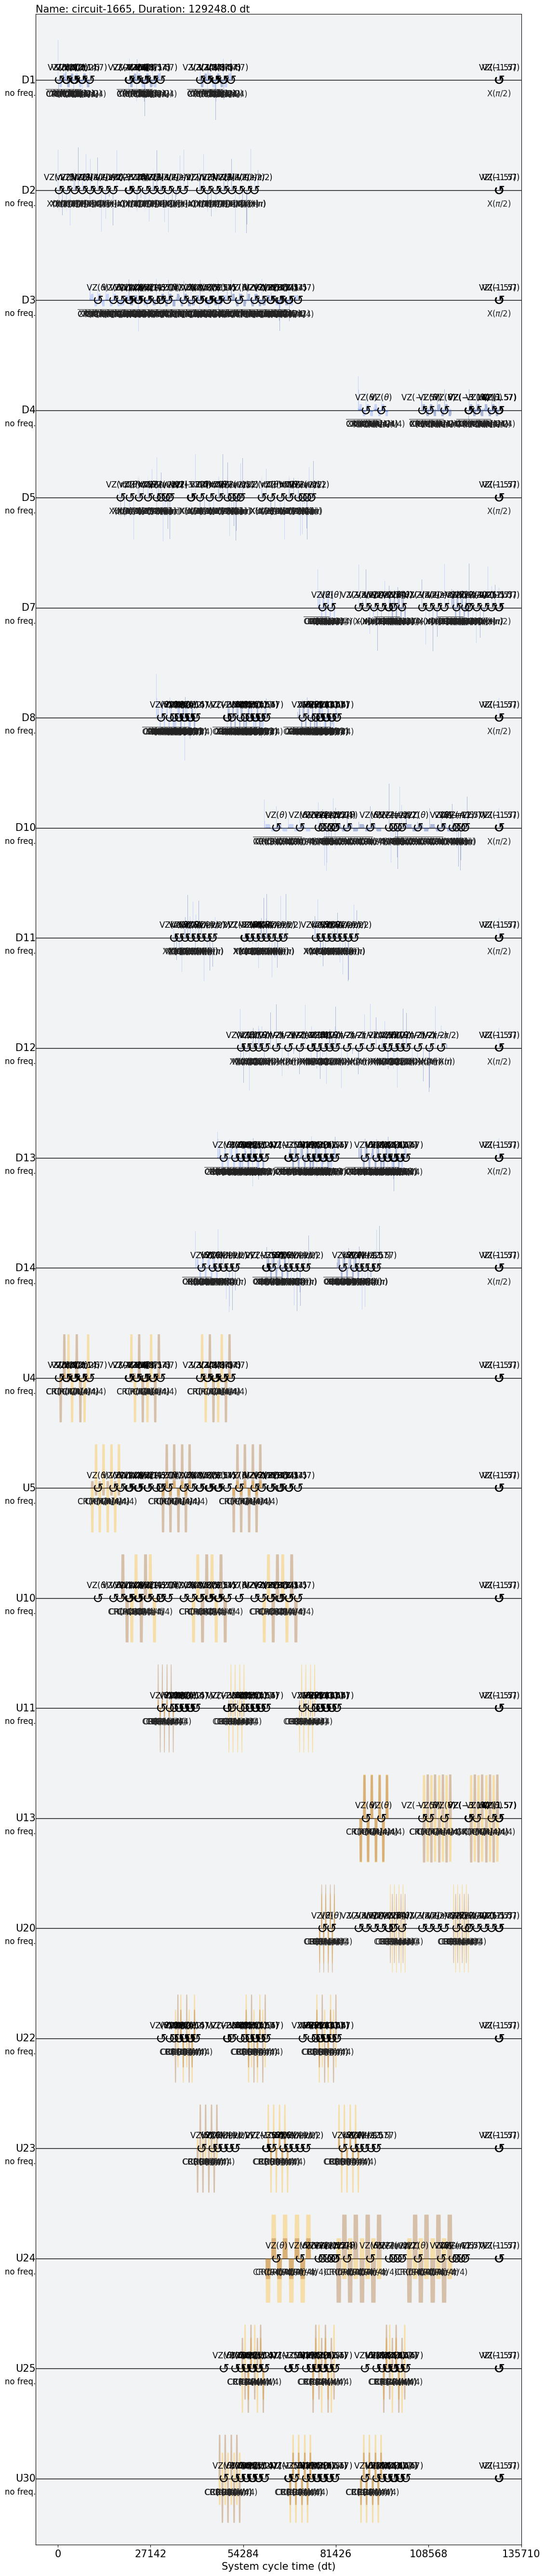

In [36]:
from qiskit import schedule
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(qc, backend=backend, initial_layout=q_layout)

pm = PassManager([RZXCalibrationBuilderNoEcho(backend)]) ## calibrate pulse efficient RZX
qc_pulse_noscale = pm.run(ansatz_opt)
qc_pulse_noscale = transpile(qc_pulse_noscale, backend)
schedule(qc_pulse_noscale, backend).draw() 


In [37]:
#qc_pulse_efficient.draw()
print(len(qc_pulse_noscale.parameters))

33


In [38]:
from stretch_pulse import *  # import script for stretching pulses

scale = [2.0, 2.5, 2.8, 3.2]

stretch_scale = scale[0] 
qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, stretch_scale)
schedule(qc_pulse_efficient, backend).draw(time_range=(0, 10000))
print(schedule(qc_pulse_efficient, backend).duration)

129248


## 2-4 Choose a classical optimizer
Select a [classical optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers). The classical optimizer will encounter errored and stochastic results from the quantum computer due to gate errors, measurement errors, and other noise sources as well as finite sampling affects [8]. Choose a classical optimizer that pairs well with your approach to VQE. Along with choosing a classical optimizer, picking an initial set of parameters plays a significant role in VQE. In this example, a random set of values is picked (shown in the `CustomVQE` class section 2-5).

\[8\] "Using models to improve optimizers for variational quantum algorithms" K. Sung, et al. [arXiv:2005.11011v2](https://arxiv.org/abs/2005.11011v2) [quant-ph] (2020)

In [39]:
from qiskit.algorithms.optimizers import SPSA, ADAM, SLSQP, L_BFGS_B, GradientDescent

#optimizer = SPSA(maxiter=100)
learning_rate = 0.001
iterations = 200
#optimizer = ADAM(maxiter=iterations, lr=learning_rate), 
#optimizer = SLSQP(maxiter=iterations)
#optimizer = L_BFGS_B(maxiter=100)
optimizer = GradientDescent(maxiter=iterations, learning_rate=learning_rate)

## 2-5 Define custom VQE program
The VQE calculation can be efficiently orchestrated between the quantum and classical computer using qiskit's [primitives](https://qiskit.org/documentation/apidoc/primitives.html). Below is a simple example of using the [Estimator primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-estimator) with your computer as a local simulator of a quantum computer. It's convenient to bring the components of VQE together into a custom class which we've called `CustomVQE`.

If you want more control over the measurement results and how the expectation values are computed, use the [Sampler primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-sampler) which will output the probabilities (or quasi-probabilities) of every measured state instead of expectation values.

In [40]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None, init_data=False):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._init_data = init_data
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        if len(self._init_data) > 0:
            x0 = init_data
        else:
            x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)

        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


### Callback
It's important to know what's going on between the classical and quantum computer during the optimization. What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?

Defining a callback function gives us a chance to peek in. A simple callback method is defined below. See [this tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html) for more information and be sure to read the classical [optimizers' docs](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for what specific values can be extracted during optimization. For example [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) returns: (nfev, parameters, value, stepsize, accepted).

In [57]:
# Define a simple callback function
intermediate_info = []
result_times = 0
def callback(value):
        global result_times
        if result_times % 50 == 0:
            print(value)
        result_times = result_times + 1    
        intermediate_info.append(value)

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [58]:
from qiskit.primitives import Estimator

In [59]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, GradientDescent, ADAM, SPSA
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance, algorithm_globals

learning_rate = 0.01
iterations = 50
optimizers = [
    COBYLA(maxiter=iterations), 
    L_BFGS_B(maxiter=iterations), 
    SLSQP(maxiter=iterations), 
    GradientDescent(maxiter=iterations, learning_rate=learning_rate),
    ADAM(maxiter=iterations, lr=learning_rate), 
    SPSA(maxiter=iterations)
]

converge_cnts = np.empty([len(optimizers)], dtype=object)

for i, optimizer_selected in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
    #algorithm_globals.random_seed = 50

    intermediate_info = []
    counts = []
    values = []
    estimator = Estimator([ansatz_opt], [ham_16])

    # Setup VQE algorithm
    custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer_selected, callback=callback, init_data=[])

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
    end = time()

    print(result)
    print(f'execution time (s): {end - start:.2f}')
    
    rel_error = rel_err(gs_energy, result.eigenvalue)
    print("Relative error ", optimizer_selected, " ", rel_error)
    
    converge_cnts[i] = np.asarray(intermediate_info)
print('\rOptimization complete      ');


Optimizer: COBYLA        -1.0223918044294547
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 50,
    'eigenstate': None,
    'eigenvalue': -4.374429072487401,
    'optimal_circuit': None,
    'optimal_parameters': array([-0.15391416, -0.18262709,  0.17004359,  0.35447361, -0.02251055,
        0.545448  ,  1.12871373, -0.10911166,  0.26974973,  0.03641829,
        0.04188304, -0.06671761, -0.47234717,  0.2807513 , -0.07985756,
       -0.67608714,  0.35108308, -0.05158119,  0.06404518,  0.5446606 ,
        1.57758105,  0.59170367,  0.02211301,  0.32499251,  0.09913156,
       -0.0786231 ,  0.64821748,  0.39333419,  0.68725637,  0.30421536,
        0.54508936,  0.52112573,  0.07017374]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 40.21
Relative error  <qiskit.algorithms.optimizers.cobyla.COBYLA object at 0x7f31b1fb8b50>   0.7569761626395888
Optimizer: L_BF

In the print out above, the ground state energy is under "eigenvalue", and the optimal choice of parameters that goes with that energy is under "optimal_parameters". Let's plot the energy convergence data the callback function acquired.

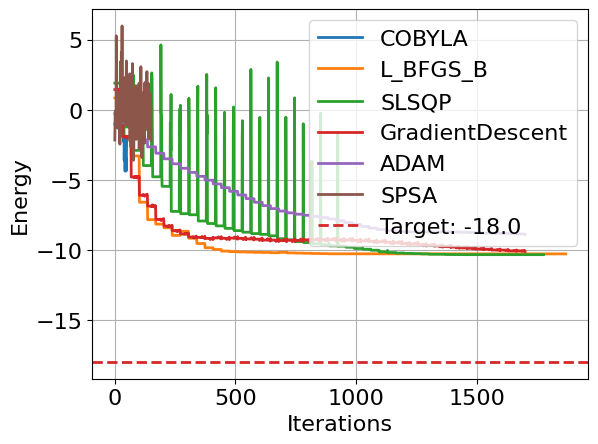

In [60]:
#plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
for i, optimizer in enumerate(optimizers):
    plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

The true ground state energy is -18.0. As a metric for how well the VQE found the ground state energy, we will compute the relative difference between -18.0 and what we just achieved with VQE. This will be the metric of performance in the judging criteria, though it's important to note that it's not the only useful metric when working with VQE. Remember that the lower the relative error the higher you will score.

Expected ground state energy: -18.0000000000
Computed ground state energy: -6.0904576051
Relative error: 0.66164124

In [61]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -2.2050119984
Relative error: 0.87749933


Scale: 0.8
Optimizer: L_BFGS_B        -0.07280726026606964
0.7713359984584047
-5.200127439316727
0.7477532170598905
-6.6047733685566925
-7.418381110751411
-7.715958305961682
-8.01442904176127
-8.67048276366483
-9.081104155140823
-9.915394004303925
-10.106754476120777
-10.227939373011283
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 680,
    'eigenstate': None,
    'eigenvalue': -10.227939373011283,
    'optimal_circuit': None,
    'optimal_parameters': array([ 2.90653154e-01,  7.11404622e-01,  3.75684617e-01,  1.05684321e-01,
        6.06006529e-01,  4.10623212e-01,  1.22064156e-01,  7.06586201e-04,
        5.15867822e-01,  3.66499457e-01,  2.22977041e-01,  5.00803801e-01,
       -2.54322642e-01,  7.61907362e-01,  3.99498789e-04,  5.04132911e-01,
        3.06356604e-01,  1.31817067e+00,  2.50736329e-04,  9.94765711e-01,
        1.15224238e+00,  8.06447732e-01,  5.03098460e-01,  2.83202615e-01,
        3.37717404e-02,  4.98321907e-01,  1.00079739e+00,  3.61474581e-01,

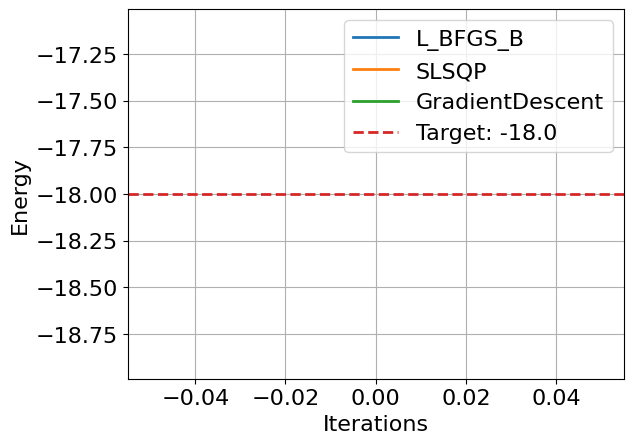

None

Scale: 1.5
Optimizer: L_BFGS_B        -1.3694925562221243
-1.8739130800259531
-4.606810471837893
-5.509983968524691
-6.8166042435852034
-7.86594124941745
-8.370526452085413
-6.197022857844046
-9.29848052834737
-9.616930416266142
-9.962411056308802
-10.123748799589126
-10.197049450994548
-10.23736811926481
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 680,
    'eigenstate': None,
    'eigenvalue': -10.237368119264806,
    'optimal_circuit': None,
    'optimal_parameters': array([ 6.91360569e-01,  3.56810035e-01,  7.34344758e-01,  4.05213607e-01,
        2.59854301e-01,  1.60133884e-01,  3.00662833e-01,  4.44786079e-01,
        4.20824163e-01,  6.32496599e-01,  1.97190089e-01,  1.39518141e-03,
        6.98443884e-01,  1.57648147e-01,  7.14327940e-04, -1.54487784e-03,
        2.45668137e-01,  7.57569448e-01,  9.96521853e-01,  5.04307812e-01,
        1.85871078e-01,  3.19232824e-01,  4.98497975e-01,  1.63345253e-01,
        9.28662933e-01,  5.06189842e-01,  4.99592525e-0

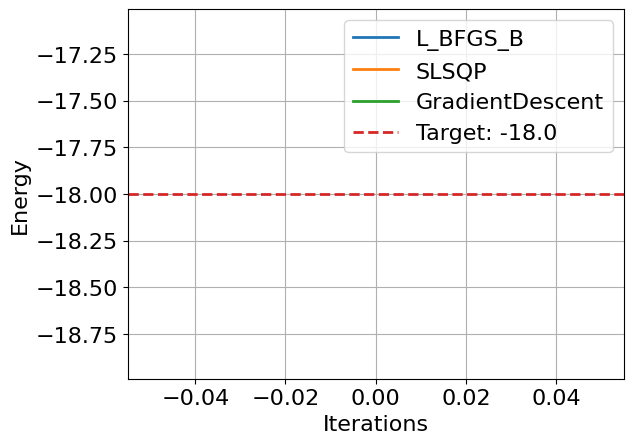

None

Scale: 2.0
Optimizer: L_BFGS_B        3.16845938937627
-2.757129437052597
-3.8352222060366112
-5.015234015168302
0.5395531135401478
-6.563469029334724
-7.9097361408698
-9.190102762348868
-9.550185641348005
-10.07170031272993
-10.208000259737151
-10.238302172049579
-10.24102898074861
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 612,
    'eigenstate': None,
    'eigenvalue': -10.241028979983184,
    'optimal_circuit': None,
    'optimal_parameters': array([ 2.64897710e-01,  1.06397389e-01,  7.21245824e-02,  1.27318679e-02,
        4.59653128e-01,  2.30054903e-01,  3.86901920e-01,  5.54808465e-01,
        1.76944716e-01,  6.04330947e-01,  2.72776706e-01, -4.07094077e-04,
        2.28315357e-01,  3.42617801e-01,  5.01737386e-01,  4.99502568e-01,
        2.45863480e-01,  7.47829643e-01,  5.00163133e-01, -7.64519327e-04,
        8.44533507e-01,  2.90161146e-01,  1.00014872e+00,  2.88055155e-01,
        3.27738028e-02, -2.88627571e-03,  5.00021377e-01,  8.62917569e-02,
   

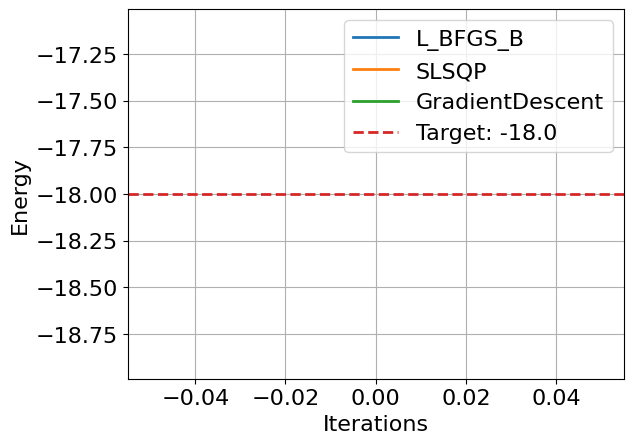

None

Scale: 2.5
Optimizer: L_BFGS_B        1.46893056222226
-2.274067467009744
-7.074635752808859
-7.545822160608249
-8.350764706578461
-8.992418590279854
-9.276514980799028
-9.626551135665931
-10.183403101064357
-10.225172707059423
-10.238577423953675
-10.241110874381643
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 578,
    'eigenstate': None,
    'eigenvalue': -10.241110873796066,
    'optimal_circuit': None,
    'optimal_parameters': array([ 4.96355409e-01,  2.67434439e-01,  5.91352014e-01,  7.62593483e-01,
        2.93690603e-01,  3.83286918e-01,  1.04268367e-01,  7.19323758e-01,
        7.28436849e-02,  1.13736867e-01,  1.84839179e-01, -7.02623730e-04,
        3.45432285e-01,  2.12946444e-01,  4.99608451e-01,  9.98782296e-01,
        1.54951975e-01,  7.59445508e-01,  7.79720283e-04,  1.06638986e-03,
        2.50879958e-01,  7.47622825e-01,  5.00443334e-01, -5.36676673e-02,
        1.86894293e-01, -4.55535897e-04,  5.01969814e-01,  1.01332255e+00,
        7.66093928e

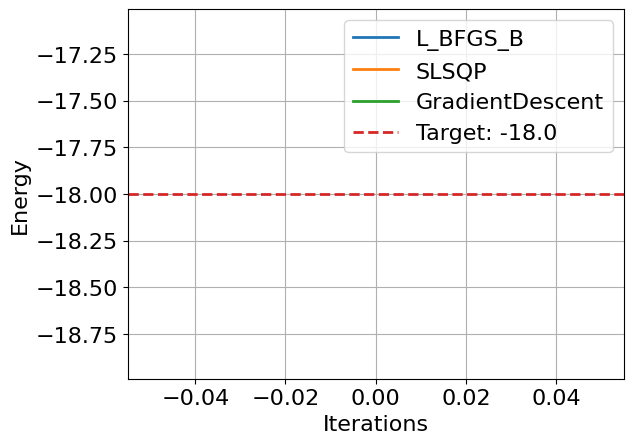

None

Scale: 2.8
Optimizer: L_BFGS_B        0.655166360240672
-3.4131666035569457
-5.188283609271021
-6.100663276297042
-7.126928117413343
-7.4374441985222
-7.9468994869654725
-8.415322096546655
-7.5306258571585465
-8.886414205540735
-9.119440491509364
-9.203375592698801
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 612,
    'eigenstate': None,
    'eigenvalue': -9.249309609628146,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.71776707,  0.15928462,  0.33518226,  0.08077692,  0.39329102,
        0.5778741 ,  0.48921684,  0.75625098,  0.62839598,  0.20810725,
        0.05175183,  0.73292011,  0.47317327,  1.03587381,  0.8853627 ,
        0.50008586,  0.75402243,  0.1743029 ,  0.48697229, -0.0039548 ,
        0.24890317, -0.28377917,  0.34458185, -0.02723971,  0.87813264,
        1.11935844, -0.00612804,  0.74421319, -0.00699873,  0.01000217,
        0.48926261,  0.77980374,  0.52785979]),
    'optimal_point': None,
    'optimal_value': None,
    'optimize

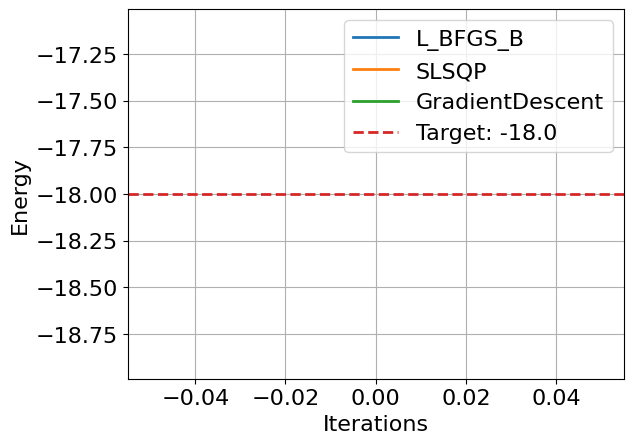

None

Scale: 3.2
Optimizer: L_BFGS_B        0.6535171507765091
0.07785493998533585
-1.6760967223545535
-5.899895157960637
-7.126232616180677
-8.1719599420727
-8.266336896566129
-8.522624375536559
-8.760418842445509
-3.47483851211214
-9.326496820054487
-8.934015105578089
-9.860864495823245
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 646,
    'eigenstate': None,
    'eigenvalue': -9.860864525138872,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.74225702,  0.15610164,  0.27033004,  0.21352475,  0.14096979,
        0.47849   ,  0.46400479,  0.55989183,  0.0540562 ,  0.43603206,
        0.57518584, -0.0077681 ,  0.90856619,  0.14836084,  0.00867571,
       -0.04249814,  0.20542268,  0.26919354,  0.5015599 ,  1.00069708,
        0.30347349,  0.78475145,  0.52272689,  1.41369787,  0.1373506 ,
        0.6269067 ,  0.47915229,  0.49490444,  0.732006  ,  0.00195693,
        0.49768191,  0.39028418,  1.13328018]),
    'optimal_point': None,
    'optimal_value': N

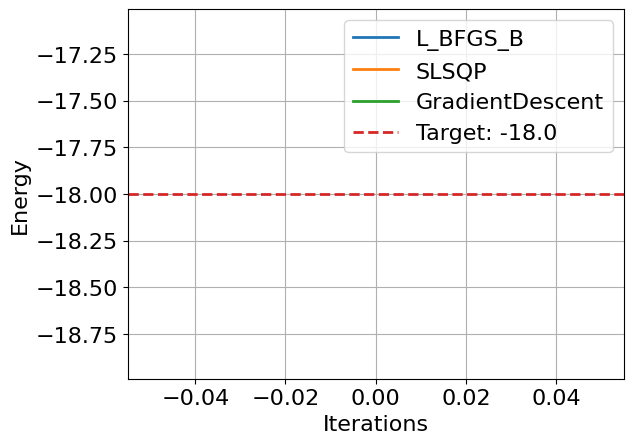

None

Scale: 4
Optimizer: L_BFGS_B        -0.8118581701143541
0.09329127908744261
-4.56299889849764
-5.6676601644561835
-2.259356488134956
-7.144865066985259
-7.989131586497385
-8.505300517990317
-8.8701330307919
-8.936021461038445
-9.381049781484869
-9.46348090754162
-9.519762469405993
-9.563451829729937
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 680,
    'eigenstate': None,
    'eigenvalue': -9.563451836618167,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.54004096,  0.21083171,  0.19610722,  0.1273516 ,  0.74691074,
        0.29849559,  0.20682501,  0.43569109,  0.04261253,  0.21508996,
        0.65430038,  0.5933182 ,  0.02731233,  0.51290587,  0.2831345 ,
        0.75898454,  0.49943911,  0.50672543,  0.28021923,  0.83061421,
        0.44154992,  0.53928694,  0.60160438,  0.54087718,  1.00488238,
       -0.00202138,  0.25010662,  0.50425089,  0.49747725,  0.20732358,
        0.47006164,  0.96420287,  0.72986501]),
    'optimal_point': None,
    '

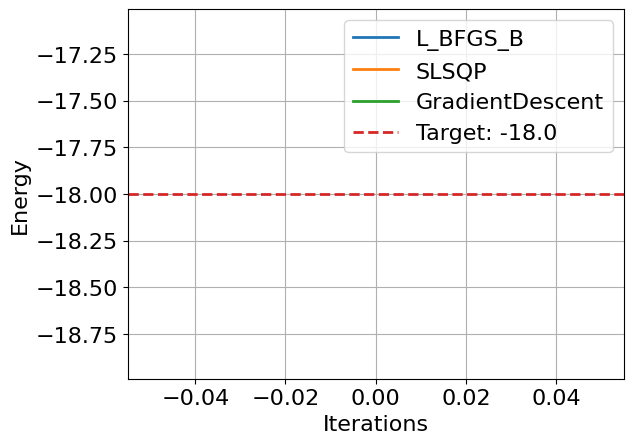

None

Scale: 6
Optimizer: L_BFGS_B        -2.123263158084833
-1.0771703622862836
-6.288683084298091
-7.376076887488719
-8.321078878990386
-8.78515963121892
-9.2330311881565
-9.340538208421716
-9.151634950671035
-9.602988977598876
-10.032384558091271
-10.06584083053172
-10.089064126642182
-10.097843693686213
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 680,
    'eigenstate': None,
    'eigenvalue': -10.097843691384485,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.07221068,  0.68272218,  0.55247949,  0.12957574,  0.30092773,
        0.62351832,  0.13356868,  0.37840531,  0.55310136,  0.33443454,
        0.18309492,  0.50062066,  0.84599569, -0.01009201,  0.24694976,
        0.23804161,  0.53721446,  0.63123483,  0.50334481,  0.50525242,
        0.75281548,  0.75328177,  0.50060619,  0.65223429,  0.50030796,
        0.69949639,  0.45036274,  0.48628054,  0.13871386,  0.0082699 ,
        0.50075585,  0.55325949,  0.80004841]),
    'optimal_point': None,
  

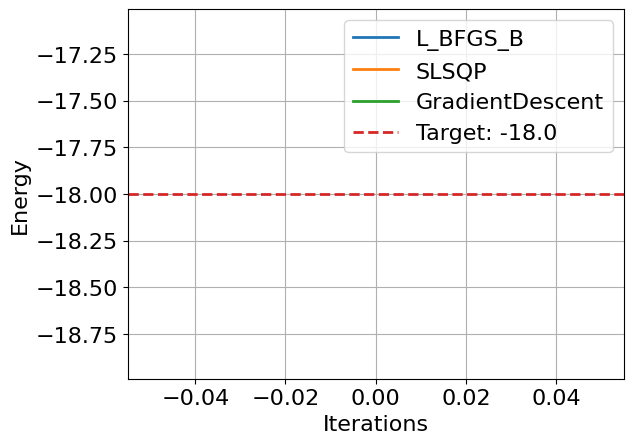

None

Without Scale:


NameError: name 'qc_pulse_noscale' is not defined

In [64]:
scale = [0.8, 1.5, 2.0, 2.5, 2.8, 3.2, 4, 6]

learning_rate = 0.01
iterations = 15
optimizers = [
    L_BFGS_B(maxiter=iterations), 
    SLSQP(maxiter=iterations), 
    GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]

def runTests(ansatz):
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=[])

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())
        
for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    runTests(qc_pulse_efficient)

print("Without Scale:")
runTests(qc_pulse_noscale) 


## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [23]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Options,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [24]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = service.get_backend('ibmq_qasm_simulator') # ibmq_qasm_simulator simulator_statevector
#backend = noisy_sim

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [25]:
# Define a simple callback function
intermediate_info_sim_backend = []
result_times = 0
def callback_sim(value):
        global result_times
        if result_times % 50 == 0:
            print(result_times, ":", value)
            #print(dir(value))
        result_times = result_times + 1   
        intermediate_info_sim_backend.append(value)

In [34]:
from qiskit_aer.noise import NoiseModel

intermediate_info_sim_backend = []
noise_model = NoiseModel.from_backend(backend)

options = Options()
options.execution.shots = 4000
options.optimization_level = 2
options.resilience_level = 1
#options.max_execution_time = None
options.simulator.noise_model = noise_model
options.resilience.noise_factors = (1,2,3,4)
options.resilience.noise_amplifer = 'CxAmplifer'
options.resilience.extrapolator = 'QuadraticExtrapolator'

optimizer = GradientDescent(maxiter=10, learning_rate=0.01)
#optimizer = SPSA(100)
#optimizer = L_BFGS_B(maxiter=20)
#options.resilience_level = 2
#options.optimization_level = 2 # 3
#options.resilience.noise_factors = (1,3)
#options.resilience.noise_amplifer = 'CxAmplifer' # GlobalFoldingAmplifier'
#options.resilience.extrapolator = 'QuadraticExtrapolator'

init_data = np.array([-0.86603815,  1.58032798,  0.51285279,  0.49809837,  0.27322768,
       -1.38178954,  1.70499464,  1.04106315,  0.51621913, -0.13731653,
        1.51602442,  1.57409059,  1.48300675, -0.37362117,  2.44508632,
        2.46544009, -0.19465347,  0.70169338,  1.5454787 ,  0.33280199,
        0.92401055, -1.13059454, -1.17564615, -0.73895974, -0.21881502,
        0.6861619 ,  1.98817126,  1.98982443, -0.63473088,  1.50349696,
       -0.01603443, -0.82929098, -1.18696454,  1.19769243,  1.9387316 ,
        0.80074161,  0.65129359, -2.40981236,  1.03409574,  0.78201563,
        2.06553563,  0.55697357,  1.61797871,  1.32715858,  0.69284758,
       -1.69754006, -0.82715879,  1.31002492,  2.11055739,  1.83372156,
        2.43731514,  0.9827094 ,  0.98712696, -0.27879709,  1.56100647,
        0.38812441, -0.73050545,  0.31826286,  2.00290782, -1.2927008 ,
        1.03245357,  1.63858376, -1.46805061, -0.53280695, -0.05916697,
        0.35601125,  2.13775833, -0.66708173,  1.72390723,  1.69577274,
        1.25149294,  0.95609532, -0.6383984 ,  1.38035714,  2.37657503,
       -0.34702142, -0.3316847 ,  1.25284588,  0.82331141,  0.31596547,
       -0.70451621,  1.54789823, -1.02347151,  1.88938479,  1.37090621,
        0.68927883,  0.71171596, -0.03321831,  0.29810749,  1.50173927,
       -0.10876964, -1.31854483,  0.15393087,  1.68347948, -0.76489741,
       -0.39157626,  1.9721524 , -0.24598029, -1.25428758, -0.59658253,
       -0.45702447, -0.03176465,  0.44900696,  1.31609364, -0.30533408,
       -0.31556375,  0.23248373, -1.04135156,  0.74669725,  2.41399292,
       -0.19952098,  1.16994097, -0.98634674,  0.21220216,  0.54195612,
       -0.30148662,  1.72003309, -0.63589896, -1.04923415,  1.60780923,
        0.30676947,  0.51521657, -0.6363995 , -0.23746074,  0.7559869 ,
        1.56839441, -0.35244649,  1.32742125, -0.00369296,  0.96840957,
       -0.74872169,  1.94878023])

# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session, options=options)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, qc_pulse_efficient, optimizer, callback=callback_sim, init_data=[])
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

/home/ts/.local/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:365: UserWarning: Qiskit backend <IBMBackend('ibmq_qasm_simulator')> has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(f"Qiskit backend {backend} has no QubitProperties, so the resulting"


KeyboardInterrupt: 

In [ ]:
print(result)

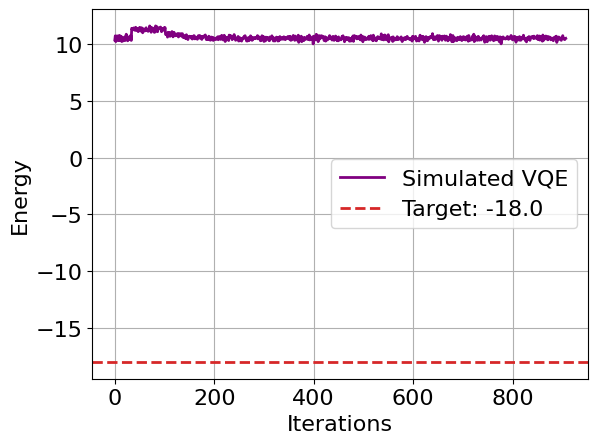

In [32]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [33]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -1.6472500000
Relative error: 0.90848611


# Qiskit Fake backend

In [ ]:
from qiskit.primitives import BackendEstimator
# Define fake backend
noisy_backend = noisy_sim

# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)
        
noisy_estimator = BackendEstimator(backend=noisy_backend)
custom_vqe = CustomVQE(noisy_estimator, qc_pulse_efficient, optimizer, callback=callback_real, init_data=None)
result = custom_vqe.compute_minimum_eigenvalue(ham_16)

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

## 3-2 Qiskit runtime Real backend (ibmq_guadalupe)

If our `qiskit_ibm_runtime` code is working on the cloud simulator backend, we can simply change the backend to the ibmq_guadalupe to run on the real backend. This may take a couple hours. Your performance score will be determined by the calculated relative error between the true ground state energy of -18.0 and the measured energy from the real ibmq_guadalupe backend.

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum')

backend = service.get_backend('ibmq_guadalupe')
#backend = noisy_sim

options = Options()
options.execution.shots = 4000
options.optimization_level = 2
options.resilience_level = 2
options.max_execution_time = None
options.resilience.noise_factors = (2,3)
options.resilience.noise_amplifer = 'CxAmplifer'
options.resilience.extrapolator = 'QuadraticExtrapolator'

optimizer = L_BFGS_B(maxiter=100)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend = []
result_times = 0
def callback_real(value):
        global result_times
        if result_times % 50 == 0:
            print(value)
        result_times = result_times + 1   
        intermediate_info_real_backend.append(value)

In [ ]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session, options=options)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, qc_pulse_efficient, optimizer, callback=callback_real, init_data=None)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
#job = backend.retrieve_job('cf0kerkq7eg6m2pp3cd0')
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## 3-3 Performance Score
Compute the relative error between the expected ground state energy and the VQE result.

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table